In [30]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm import tqdm

plt.style.use('dark_mode')

# Create Body Objects

In [31]:
class Body:
    def __init__(self, position, radius):
        self.position = position
        self.radius = radius
        self.angular_size = 1

    def calc_position(self, t):
        """
        A function to update the position of the planet. We use a simple parametric 
        equation in cylindrical coordinates.
        """
        x,y,z = 2*np.cos(((t * 2* np.pi) / (N_frames))+ np.pi/2), 2*np.sin(((t * 2* np.pi) / (N_frames)) + np.pi/2), 0
        self.position = np.array([x, y, 0 ])
        
    def calc_projection(self, t):
        """
        We set up a camera in the y-plane to compute the projected perspective.
        """
        camera_ = np.array([0,-1 * Camera_Distance,0])
        dr_vec = self.position - camera_
        distance = np.linalg.norm(dr_vec)
        
        self.angular_size = self.radius / distance
        
        return distance


# Physics/Math Functions for Calculating Brightness Dip

In [32]:
def area_overlap(circle_A, circle_B):
    """
    A function to compute the overlapping projected area of 2 circles (using angular size for perspective).
    """
    
    d = np.sqrt((circle_B.position[0] - circle_A.position[0])**2 + (circle_B.position[2] - circle_A.position[2])**2)

    if d < (circle_A.angular_size + circle_B.angular_size):
        
        a = circle_A.angular_size**2
        b = circle_B.angular_size**2
        
        x = (a - b + d**2) / (2 * d)
        z = x**2

        y = np.sqrt(np.abs(a - z))

        if d <= np.abs(circle_B.angular_size - circle_A.angular_size):
            AREA = np.pi * min(a, b)
        else:  
            AREA = a * np.arcsin(y / circle_A.angular_size) + b * np.arcsin(y / circle_B.angular_size) - y * (x + np.sqrt(z + b - a))
        
        
        return AREA
    
    return 0
    
    
def calc_blocked_light(star,planet, t):
    """
    A function to calculate the amount of light blocked by the planet.
    """
    area_star = np.pi * star.angular_size**2
    
    d_planet = planet.calc_projection(t)
    d_sun = star.calc_projection(t)
    
    if d_planet < d_sun:
        area_planet = area_overlap(star,planet)
    else:
        area_planet = 0
        

    return 1 - (area_planet / area_star)

# Plotting Function for Animation

In [33]:
def draw(axes, camera, t, Sun, Planet, brightness_curve, times):
    """
    A function to draw the exoplanet orbit and the lightcurve.
    """
    
    #physics
    Planet.calc_position(t)
    
    d_planet = Planet.calc_projection(t)
    d_sun = Sun.calc_projection(t)
    
    brightness_dip = calc_blocked_light(Sun,Planet, t)
    brightness_curve.append(brightness_dip)
    times.append(t)
    
    #plotting
    axes[1].plot(times, brightness_curve,linewidth=2, color="white")
    axes[1].plot(times[-1], brightness_curve[-1], marker="o", color="white")
    axes[1].set_ylim(0.99,1.002)
    axes[1].set_xlim(0,N_frames)
    axes[1].set_xlabel("Days")
    axes[1].set_ylabel("Brightness Dip")
    
    if d_planet > d_sun:
        
        planet = plt.Circle((Planet.position[0], Planet.position[2]), Planet.angular_size, color='cyan')
        axes[0].add_patch(planet)
        
        sun = plt.Circle((Sun.position[0],Sun.position[1]), Sun.angular_size, color='red', zorder=10)
        axes[0].add_patch(sun)
        
    else:
        sun = plt.Circle((Sun.position[0],Sun.position[1]), Sun.angular_size, color='red')
        axes[0].add_patch(sun)
        
        planet = plt.Circle((Planet.position[0], Planet.position[2]), Planet.angular_size, color='cyan', zorder=10)
        axes[0].add_patch(planet)
        
    plt.tight_layout()
        
    camera.snap()

# Main Loop

In [34]:
def main():
    """
    Main loop hosted within this function. This runs the entire simulation.
    """

    #setup the sim
    Sun = Body(np.zeros(3), Star_Radius)
    Planet = Body(np.array([0,1,0]), Planet_Radius)
    
    #create the figure
    fig, axes = plt.subplots(2,1, figsize=(6, 6), gridspec_kw={'hspace':0.0})
    axes[0].set_title("Exoplanet Transit", pad = 10)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_xlim(-3,3), axes[0].set_ylim(-3,3)
    axes[0].axis('equal')

    
    camera = Camera(fig)

    brightness_curve, times = [], []
    #Main Loop for Simulation!
    for frame in tqdm(range(N_frames)):
        draw(axes, camera, frame, Sun, Planet, brightness_curve, times)
        
    animation = camera.animate(blit=True)

    #save animation
    animation.save('../outputs/exoplanet.gif', fps=30)

# Run Simulation

100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 28.21it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


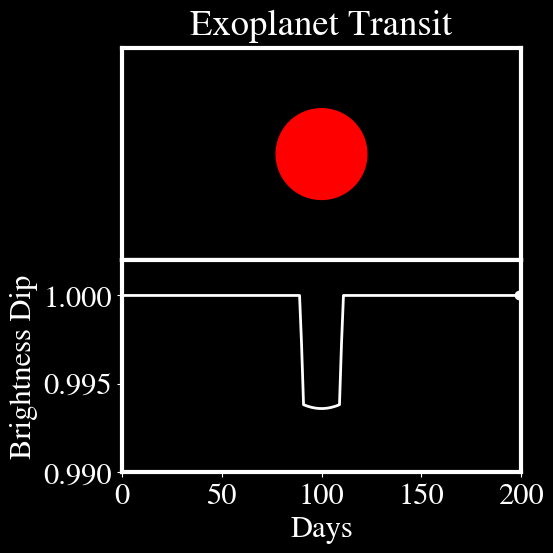

In [35]:
N_frames = 200
Star_Radius = 5
Planet_Radius = 0.3
Camera_Distance = 8
main()